# Deep Learning with MNIST

In [ ]:
# for this script to work you have to install the python packages by running the command:
# pip install scikit-learn numpy matplotlib pandas tqdm ipywidgets

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(12345)

In [ ]:
def initialize(input_dim , hidden_dim , output_dim , batch_size):
    W1 = np.random.randn(hidden_dim , input_dim) * 0.01
    b1 = np.zeros((hidden_dim,))
    W2 = np.random.randn(output_dim , hidden_dim) * 0.01
    b2 = np.zeros((output_dim,))
    # list of all network parameters
    parameters = [W1, b1 , W2, b2]
    return parameters

### Define activation functions

In [ ]:
def sigmoid(x):
    # we are clipping x to the range [-1000, 1000] to prevent overflowing numbers
    x = np.clip(x, -500, 500)
    return 1.0/(1.0+np.exp(-x))

In [ ]:
def dsigmoid(x):
    # assume here that the input is x=sigmoid(y), if not: return sigmoid(x) * (1-sigmoid(x))
    return x * (1 - x)

### Define Loss Functions

In [ ]:
def loss(predictions,targets):
    batch_size = targets.shape[-1]
    l = np.sum(0.5 * np.linalg.norm(predictions - targets, axis=1, ord=2)**2, axis=0) / batch_size
    return l

In [ ]:
def dloss(predictions,targets):
    batch_size = targets.shape[-1]
    dl = (predictions - targets) / batch_size
    return dl

### Helper Functions

In [ ]:
def convert_to_1d_vector(parameters):
    W1, b1, W2, b2 = parameters
    params = np.concatenate([W1.ravel(), b1.ravel(),
                             W2.ravel(), b2.ravel()], axis=0)

    return params

In [ ]:
def convert_to_list(params, input_dim, hidden1_dim, output_dim):
    base_idx = 0

    W1 = np.reshape(params[base_idx: base_idx + input_dim * hidden1_dim],
                    (hidden1_dim, input_dim))
    base_idx += input_dim * hidden1_dim

    b1 = params[base_idx: base_idx + hidden1_dim]
    base_idx += hidden1_dim

    W2 = np.reshape(params[base_idx: base_idx + hidden1_dim * output_dim],
                    (output_dim, hidden1_dim))
    base_idx += hidden1_dim * output_dim

    b2 = params[base_idx: base_idx + output_dim]

    parameters = [W1, b1, W2, b2]

    return parameters

In [ ]:
def visualize(X,y,name):
    """Visualize the MNIST dataset. Show 5 neighboured, randomly chosen digits."""
    N = X.shape[0]
    end = np.round(np.random.rand()*N).astype('int')
    start = end - 5
    plt.figure(figsize=(20,4))
    for index, (image, label) in enumerate(zip(X[start:end], y[start:end])):
        plt.subplot(1, 5, index + 1)
        plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
        plt.title(name + ': ' + str(label), fontsize = 20)
    plt.show()

In [ ]:
def vectorized_results(y):
    """Returns a one-hot-coded vector [0,0,1,0,0,0,0,0,0] which represents a digit (here 3).
    This is used to compare to the output of the neural network."""
    v = np.zeros(10)
    #####################
    #
    #   Your code here
    #   TODO: compute the one-hot encoded vector
    v[y]=1
    #####################

    return v

In [ ]:
def devectorize_results(y):
    """Returns the predicted digit from a one-hot-coded vector. [0,0,1,0,0,0,0,0,0] will give 3."""
    v = 0

    #####################
    #
    #   Your code here
    #   TODO: find the output neuron with the highest value and return its index
    v = np.argmax(y)
    #####################

    return v

In [ ]:
def update_mini_batch(net, mini_batch, learning_rate):
    """Most of the training is done here.
    Weights + biases are updated for mini-batch"""

    N = mini_batch.shape[1]
    y = mini_batch[:,N-net.output_dim:N].T
    x = mini_batch[:,0:N-net.output_dim].T

    activations = net.forward(x)
    loss_value = loss(activations, y)
    dParameters = net.backward(targets=y)

    #####################
    #
    #   Your code here
    #   TODO: update the parameters based on the computed gradients (dParameters) and the given learning rate
    for i in range(len(net.parameters)):
        net.parameters[i] -= learning_rate * dParameters[i]

    #####################

    return net.parameters, loss_value

In [ ]:
# Train neural network with stochastic gradient descent.
def train(net, train_data, label_data, epochs=1000, batch_size=5, learning_rate=0.01):
    N = len(train_data)
    data = np.concatenate([train_data,label_data],axis=1)

    losses = list()
    for i in tqdm(range(epochs)):
        # stochastic mini batch
        np.random.shuffle(data)
        # divide data set into batch_size/N parts
        mini_batches = [data[j:j+batch_size] for j in range(0,N,batch_size)]
        for mini_batch in mini_batches:
            _, loss_value = update_mini_batch(net, mini_batch, learning_rate)
            losses.append(loss_value)

    return net.parameters, losses

### Neural Net

In [ ]:
class NeuralNet(object):
    def __init__(self, batch_size=5, input_dim=3, hidden_dim=4, output_dim=2):
        self.batch_size = batch_size

       # size of layers
        self.input_dim = input_dim
        self.hidden_dim_1 = hidden_dim
        self.output_dim = output_dim

        self.placeholder_in = np.ones((self.input_dim, self.batch_size))
        self.placeholder_latent1 = np.ones((self.hidden_dim_1, self.batch_size))
        self.placeholder_out = np.ones((self.output_dim, self.batch_size))

        self.parameters = initialize(input_dim, hidden_dim, output_dim, batch_size)

        self.W1, self.b1, self.W2, self.b2 = self.parameters
        self.parameters = convert_to_1d_vector(self.parameters)

    def forward(self, x):

        # input activations
        self.placeholder_in = np.zeros((self.input_dim, x.shape[1])) # !CODE PLACEHOLDER! OVERWRITE BELOW!

        # hidden layer activations
        self.placeholder_latent1 = np.zeros((self.hidden_dim_1, x.shape[1])) # !CODE PLACEHOLDER! OVERWRITE BELOW!

        # output activation
        self.placeholder_out = np.zeros((self.output_dim, x.shape[1])) # !CODE PLACEHOLDER! OVERWRITE BELOW!

        #####################
        #
        #   Your code here
        #   TODO: Perform the forward pass and compute the activations of the input layer, the hidden layer and the output layer
        self.placeholder_in = x

        aff_lay1 = np.dot(self.W1,self.placeholder_in) + self.b1[:, np.newaxis]
        self.placeholder_latent1 = sigmoid(aff_lay1)

        self.placeholder_out = np.dot(self.W2, self.placeholder_latent1) + self.b2[:, np.newaxis]
        #####################

        return self.placeholder_out

    def backward(self, targets):

        [self.W1, self.b1, self.W2, self.b2] = convert_to_list(self.parameters, self.input_dim,
                                                                                 self.hidden_dim_1,
                                                                                 self.output_dim)

        dw1 = np.zeros((self.hidden_dim_1, self.input_dim)) # !CODE PLACEHOLDER! OVERWRITE BELOW!
        db1 = np.zeros((self.hidden_dim_1,)) # !CODE PLACEHOLDER! OVERWRITE BELOW!

        dw2 = np.zeros((self.output_dim, self.hidden_dim_1)) # !CODE PLACEHOLDER! OVERWRITE BELOW!
        db2 = np.zeros((self.output_dim,)) # !CODE PLACEHOLDER! OVERWRITE BELOW!

        #####################
        #
        #   Your code here
        #   TODO: Perform the backward pass and compute the gradients for each of the parameters in the neural network
        dout = dloss(self.placeholder_out, targets)
        dw2 = np.dot(dout,self.placeholder_latent1.T)
        db2 = np.sum(dout,axis=1)


        d_before_active = np.dot(self.W2.T, dout)
        d_affl1 = d_before_active*dsigmoid(self.placeholder_latent1)

        dw1 = np.dot(d_affl1,self.placeholder_in.T)
        db1 = np.sum(d_affl1, axis = 1)

        #####################

        dParameters = convert_to_1d_vector([dw1, db1, dw2, db2])

        return dParameters

    def predict(self, x, parameters):
        """Predict a test data set on the trained parameters."""
        self.W1, self.b1, self.W2, self.b2 = convert_to_list(parameters, self.input_dim,
                                                                               self.hidden_dim_1,
                                                                               self.output_dim)
        return self.forward(x)

In [ ]:
def read_data(normalize_data=False, random_state=0):
    print("Reading the data...")

    # get data set: MNIST digits
    mnist = fetch_openml('mnist_784')
    X = np.array(mnist.data.astype('float64')) #shape: 1000 examples of 28x28px images
    y = np.array(mnist.target, dtype='int')

    # split into training and test data set. Reduce size to 1000/300 samples instead of 60000/10000
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, test_size=300, random_state=random_state)

    if normalize_data:
        # remove the mean from the data and scale to unit variance
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    print("Finished reading the data")

    return [X_train, X_test, y_train, y_test]

In [ ]:
def run(data, hidden_dim=15, output_dim=10, batch_size=10, epochs=500, learning_rate=0.01):
    X_train, X_test, y_train, y_test = data

    print('That is what the data set looks like:')
    visualize(X_train,y_train, 'Training')

    # bring labels into one-hot-coded vector form
    expected = np.array([vectorized_results(y) for y in y_train])

    net = NeuralNet(batch_size=batch_size, input_dim=784, hidden_dim=hidden_dim, output_dim=output_dim)

    # Training
    parameters, losses = train(net, X_train, expected, epochs, batch_size, learning_rate=learning_rate)

    print('The loss decreasing during training:')
    plt.figure(figsize=(12,6))
    plt.plot(losses)
    plt.show()

    # Prediction
    predicted = net.predict(X_test.T, parameters).T

    expected = y_test
    predicted = [devectorize_results(y) for y in predicted]

    print('Here are some predicted examples:')
    visualize(X_test, predicted, 'Test')

    # Results
    print('Classification report :')
    print(classification_report(expected, predicted ))
    print('Confusion matrix:')
    print(confusion_matrix(expected, predicted))

In [ ]:
def gradient_check(parameters, gradients, X, Y, loss, forward_pass, eps=1e-7):
    """
    Performs the gradient check by calculating the numerical gradient
    using the central difference method.
    """
    W1, b1, W2, b2 = parameters
    network_structure = [X.shape[0], W1.shape[0], W2.shape[0]]

    # convert a list of parameters to a single vector
    params = convert_to_1d_vector(parameters)
    grads = gradients

    n_params = len(params)
    losses_plus = np.zeros((n_params,))
    losses_minus = np.zeros((n_params,))
    num_grads = np.zeros((n_params,))

    for i in range(n_params):
        params_eps_plus = np.copy(params)
        params_eps_plus[i] += eps

        parameters_plus = convert_to_list(params_eps_plus, *network_structure)

        activations = forward_pass(parameters_plus, X)
        losses_plus = loss(activations, Y)

        params_eps_minus = np.copy(params)
        params_eps_minus[i] -= eps

        parameters_minus = convert_to_list(params_eps_minus, *network_structure)

        activations = forward_pass(parameters_minus, X)
        losses_minus = loss(activations, Y)

        num_grads[i] = (losses_plus - losses_minus) / (2*eps)

    diff = np.linalg.norm(grads - num_grads) / (np.linalg.norm(grads) + np.linalg.norm(num_grads))

    return diff

In [ ]:
def run_gradient_check():
    input_dim = 3
    hidden_dim = 4
    output_dim = 2
    batch_size = 5

    net = NeuralNet(batch_size=batch_size, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
    X = np.random.rand(input_dim, batch_size)
    Y = np.random.randn(output_dim, batch_size)
    parameters = [net.W1, net.b1, net.W2, net.b2]

    activations = net.forward(X)
    loss_value = loss(activations, Y)
    print('Loss: {}'.format(loss_value))

    grads = net.backward(targets=Y)

    def forward_pass(params, x):
        net.W1, net.b1, net.W2, net.b2 = params
        return net.forward(x)

    diff = gradient_check(parameters, grads, X, Y, loss, forward_pass=forward_pass)

    print('Gradient checking: ')
    if diff < 1e-7:
        print('\tPassed')
    else:
        print('\tFailed')

In [ ]:
run_gradient_check()

Loss: 1.0332463475924982
Gradient checking: 
	Passed


In [ ]:
# read the dataset
data = read_data()
normalized_data = read_data(normalize_data=True)

Reading the data...


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Finished reading the data
Reading the data...


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Finished reading the data


That is what the data set looks like:


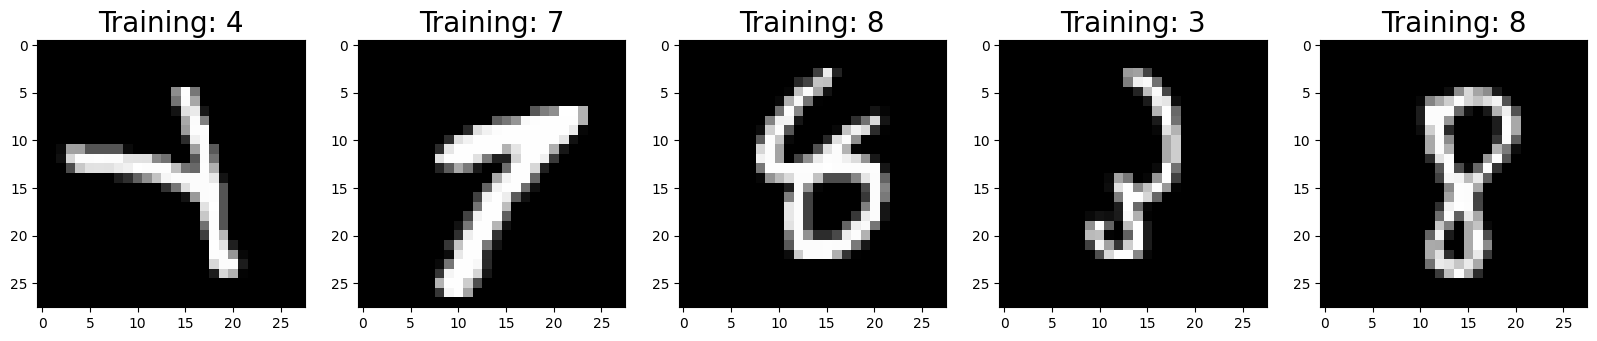

100%|██████████| 200/200 [01:34<00:00,  2.12it/s]


The loss decreasing during training:


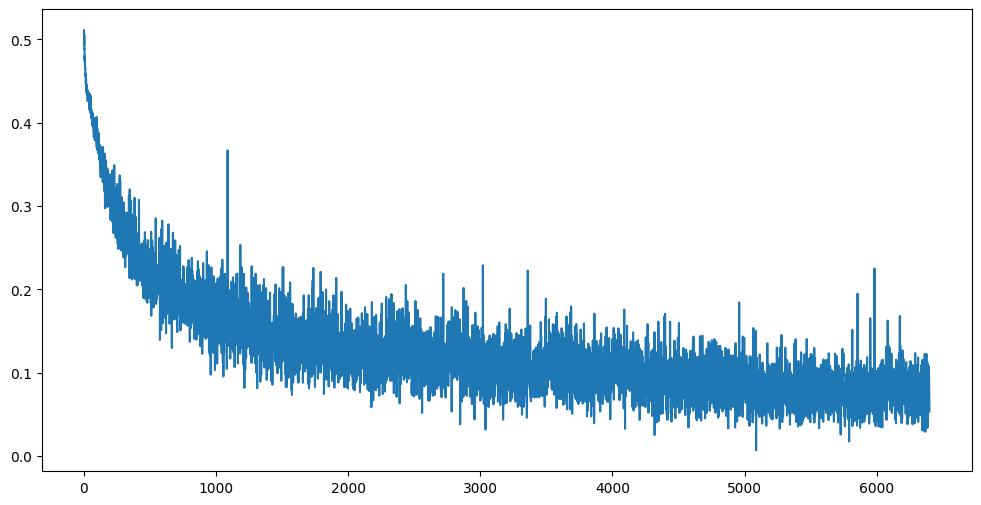

Here are some predicted examples:


<Figure size 2000x400 with 0 Axes>

Classification report :
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        33
           1       1.00      0.97      0.98        29
           2       0.86      0.79      0.83        24
           3       0.81      0.83      0.82        36
           4       0.97      0.80      0.88        40
           5       0.86      0.73      0.79        26
           6       0.77      1.00      0.87        24
           7       0.92      0.94      0.93        35
           8       0.85      0.74      0.79        31
           9       0.58      0.86      0.69        22

    accuracy                           0.85       300
   macro avg       0.86      0.85      0.85       300
weighted avg       0.87      0.85      0.86       300

Confusion matrix:
[[29  0  0  0  0  2  2  0  0  0]
 [ 0 28  1  0  0  0  0  0  0  0]
 [ 1  0 19  1  0  0  2  0  0  1]
 [ 0  0  1 30  0  0  0  1  0  4]
 [ 0  0  0  1 32  0  2  0  0  5]
 [ 0  0  0  2  0 19  1  0  4  0]
 

In [ ]:
np.random.seed(42)
run(data, batch_size=32, epochs=200)

That is what the data set looks like:


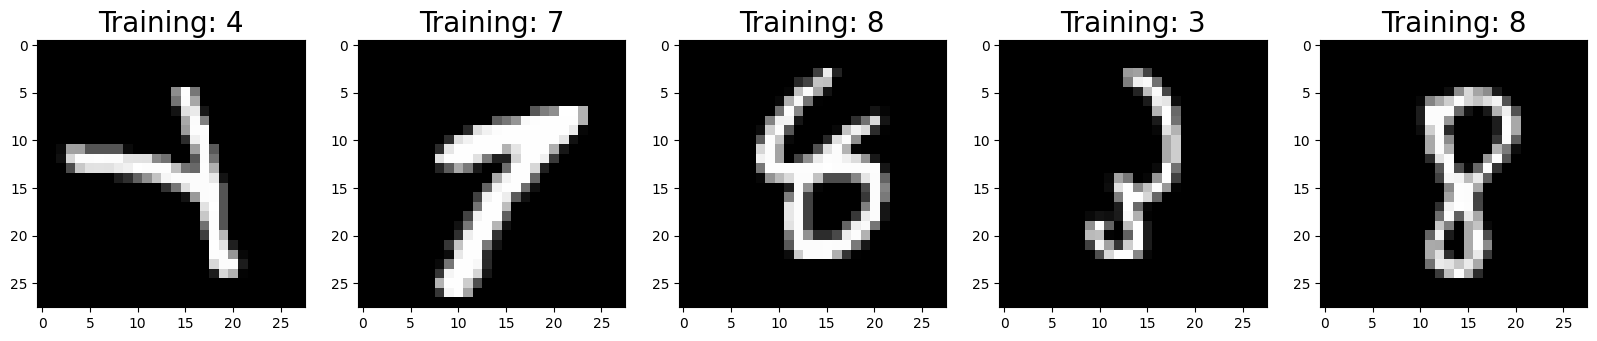

100%|██████████| 200/200 [01:33<00:00,  2.13it/s]


The loss decreasing during training:


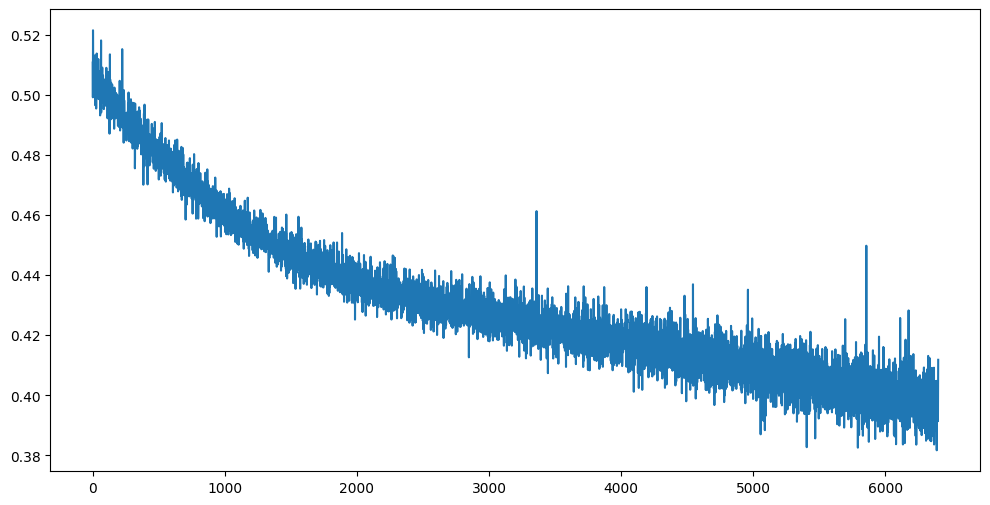

Here are some predicted examples:


<Figure size 2000x400 with 0 Axes>

Classification report :
              precision    recall  f1-score   support

           0       0.62      0.70      0.66        33
           1       0.59      0.79      0.68        29
           2       0.71      0.21      0.32        24
           3       0.73      0.22      0.34        36
           4       0.57      0.10      0.17        40
           5       1.00      0.04      0.07        26
           6       0.63      0.92      0.75        24
           7       0.57      0.86      0.68        35
           8       0.32      0.61      0.42        31
           9       0.22      0.50      0.31        22

    accuracy                           0.49       300
   macro avg       0.60      0.49      0.44       300
weighted avg       0.60      0.49      0.44       300

Confusion matrix:
[[23  0  1  0  0  0  2  0  1  6]
 [ 0 23  0  0  0  0  2  0  4  0]
 [ 1  2  5  0  1  0  3  0  8  4]
 [ 6  6  0  8  0  0  1  5  9  1]
 [ 0  0  0  0  4  0  3  7  3 23]
 [ 5  1  0  2  1  1  2  2 10  2]
 

In [ ]:
np.random.seed(42)
run(data, batch_size=32, epochs=200, learning_rate=0.0001)